In [1]:
!nvidia-smi

Mon Jan 11 20:09:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166...  On   | 00000000:01:00.0  On |                  N/A |
| 26%   35C    P8    15W / 125W |    424MiB /  5936MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [3]:
DATA_DIR = './dataset/segmentation/'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'name', 'birthday', 'countryside', 'address', 'identity number']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = glob.glob(f"{images_dir}/*.jpg")
        self.masks_fps = glob.glob(f"{masks_dir}/*.png")
        self.images_fps.sort()
        self.masks_fps.sort()
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (480, 480))
        
        # for test dataset
        if len(self.masks_fps) - 1 < i:
            mask = np.zeros(image.shape, dtype=np.float)
        else:
            mask = cv2.imread(self.masks_fps[i], 0)
        
        mask = cv2.resize(mask, (480, 480))
#         extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

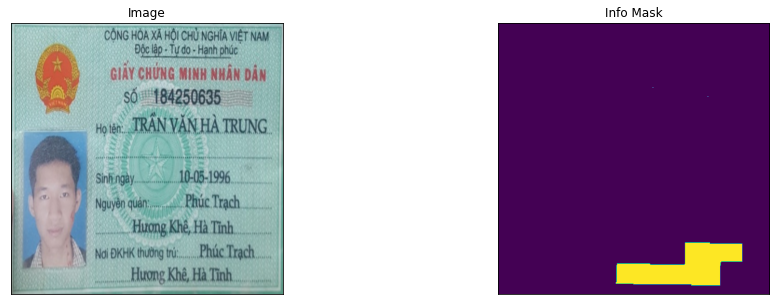

In [8]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['address'])

image, mask = dataset[1] # get some sample

visualize(
    image=image, 
    info_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [9]:
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
import time

In [ ]:
def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32')
    
    return x.astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [45]:
def get_training_augmentation():
    train_transform = [

        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0.1, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=480, min_width=480, always_apply=True, border_mode=0),

#         albu.RandomCrop(height=480, width=480, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.5),
        albu.IAAPerspective(p=0.1),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#         albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


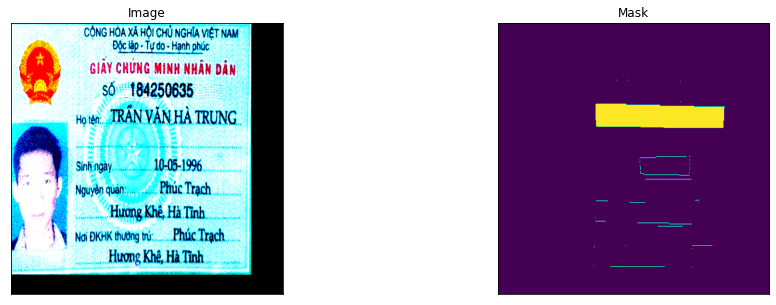

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


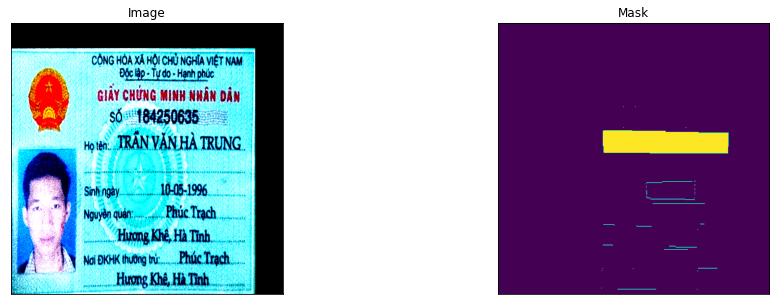

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


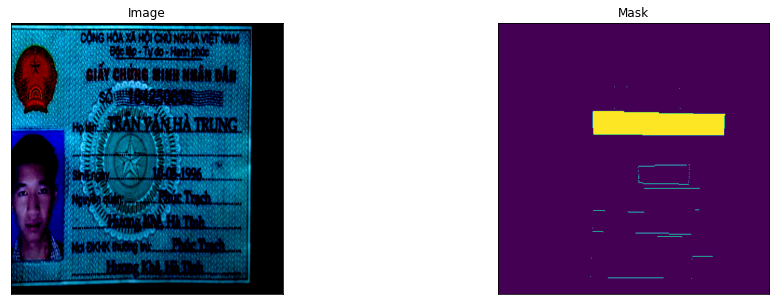

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


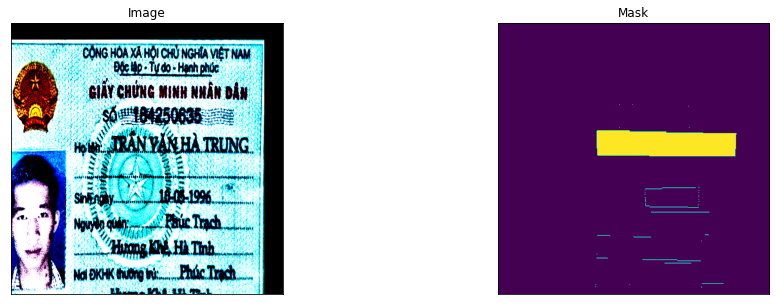

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


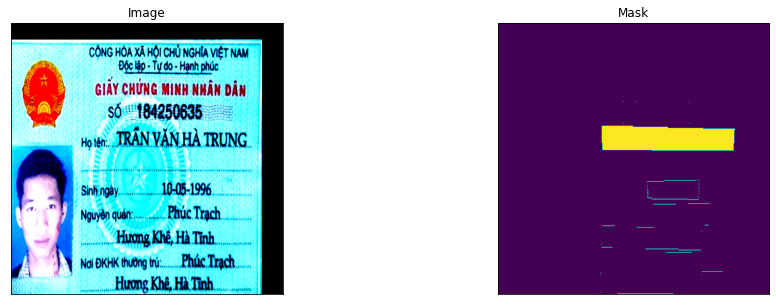

In [46]:
#### Visualize resulted augmented images and masks
ENCODER = 'vgg13_bn'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['name'],
)

# same image with different random transforms
for i in range(5):
    image, mask = augmented_dataset[1]
    visualize(image=image.transpose(1, 2, 0), mask=mask.transpose(1, 2, 0))

## Create model and train

In [ ]:
# !pip install -q segmentation_models_pytorch
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
CLASSES = ['name', 'birthday', 'countryside', 'address', 'identity number']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
start_time = time.time()
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
print("End time:", time.time() - start_time)

End time: 2.6872236728668213


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.6/dist-packages/albumentations/imgaug/transforms.py:319: UserWarning: This augmentation is deprecated. Please use Perspective instead
  warnings.warn("This augmentation is deprecated. Please use Perspective instead")
/usr/local/lib/python3.6/dist-packages/albumentations/imgaug/transforms.py:185: UserWarning: This augmentation is deprecated. Please use Sharpen instead
  warnings.warn("This augmentation is deprecated. Please use Sharpen instead")


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 56/56 [00:02<00:00, 22.07it/s, dice_loss - 0.3771, iou_score - 0.5299]
Model saved!

Epoch: 1
valid: 100%|██████████| 56/56 [00:02<00:00, 21.76it/s, dice_loss - 0.1925, iou_score - 0.7027]
Model saved!

Epoch: 2
valid: 100%|██████████| 56/56 [00:02<00:00, 21.70it/s, dice_loss - 0.1433, iou_score - 0.7673]
Model saved!

Epoch: 3
valid: 100%|██████████| 56/56 [00:02<00:00, 22.03it/s, dice_loss - 0.1266, iou_score - 0.7913]
Model saved!

Epoch: 4
valid: 100%|██████████| 56/56 [00:02<00:00, 21.84it/s, dice_loss - 0.1144, iou_score - 0.8095]
Model saved!

Epoch: 5
valid: 100%|██████████| 56/56 [00:02<00:00, 21.97it/s, dice_loss - 0.1052, iou_score - 0.8229]
Model saved!

Epoch: 6
valid: 100%|██████████| 56/56 [00:02<00:00, 22.11it/s, dice_loss - 0.1035, iou_score - 0.8254]
Model saved!

Epoch: 7
valid: 100%|██████████| 56/56 [00:02<00:00, 21.96it/s, dice_loss - 0.1005, iou_score - 0.829]
Model saved!

Epoch: 8
valid: 100%|██████████| 56/56 [00:02<00:00, 21.

In [ ]:
!cp best_model.pth '/content/drive/MyDrive/Colab Notebooks/info_segmentation.pth'